In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading MNIST dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.49MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.label_embedding = nn.Embedding(num_classes, num_classes)  # Embed labels

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)  # Convert labels to embeddings
        x = torch.cat((noise, label_embedding), dim=1)  # Concatenate noise & labels
        img = self.model(x)
        img = img.view(img.size(0), *self.img_shape)  # Reshape to image
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape
        self.label_embedding = nn.Embedding(num_classes, num_classes)  # Embed labels

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels)  # Convert labels to embeddings
        x = torch.cat((img.view(img.size(0), -1), label_embedding), dim=1)  # Flatten image & concatenate label
        validity = self.model(x)  # Predict real/fake
        return validity

In [ ]:
# Model params
latent_dim = 100
num_classes = 10
img_shape = (1, 28, 28)  # Image size

# Initialize models
generator = Generator(latent_dim, num_classes, img_shape)
discriminator = Discriminator(num_classes, img_shape)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0002
b1, b2 = 0.5, 0.999  # Adam params
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

BCELoss()

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]

        # Move to GPU if available
        imgs, labels = imgs.to(device), labels.to(device)

        #  Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        real_pred = discriminator(imgs, labels)
        real_loss = adversarial_loss(real_pred, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z, labels)
        fake_pred = discriminator(gen_imgs.detach(), labels)
        fake_loss = adversarial_loss(fake_pred, fake_labels)

        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        #  Train Generator
        optimizer_G.zero_grad()

        # Generator loss (wants D(G(z, y)) to be 1)
        fake_pred = discriminator(gen_imgs, labels)
        g_loss = adversarial_loss(fake_pred, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [1/25] | D Loss: 0.3875 | G Loss: 3.3266
Epoch [2/25] | D Loss: 1.4890 | G Loss: 3.2571
Epoch [3/25] | D Loss: 0.3772 | G Loss: 5.9287
Epoch [4/25] | D Loss: 0.0835 | G Loss: 4.4216
Epoch [5/25] | D Loss: 0.0882 | G Loss: 3.6197
Epoch [6/25] | D Loss: 2.0108 | G Loss: 6.6731
Epoch [7/25] | D Loss: 0.2076 | G Loss: 1.4534
Epoch [8/25] | D Loss: 0.0104 | G Loss: 5.4370
Epoch [9/25] | D Loss: 0.0961 | G Loss: 4.7330
Epoch [10/25] | D Loss: 0.0022 | G Loss: 6.4680
Epoch [11/25] | D Loss: 0.0005 | G Loss: 7.8330
Epoch [12/25] | D Loss: 0.0002 | G Loss: 8.9419
Epoch [13/25] | D Loss: 0.0001 | G Loss: 9.6058
Epoch [14/25] | D Loss: 0.0000 | G Loss: 10.9688
Epoch [15/25] | D Loss: 0.0000 | G Loss: 11.1966
Epoch [16/25] | D Loss: 0.0000 | G Loss: 10.5504
Epoch [17/25] | D Loss: 0.0001 | G Loss: 10.0840
Epoch [18/25] | D Loss: 0.0001 | G Loss: 9.0302
Epoch [19/25] | D Loss: 0.0003 | G Loss: 8.3631
Epoch [20/25] | D Loss: 0.0002 | G Loss: 10.2375
Epoch [21/25] | D Loss: 0.0003 | G Loss: 10.

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

# Create directory if not exists
save_dir = "/content/drive/MyDrive/cGAN_models"
os.makedirs(save_dir, exist_ok=True)

# Save generator & discriminator
torch.save(generator.state_dict(), os.path.join(save_dir, "generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(save_dir, "discriminator.pth"))

print(f"Models saved to {save_dir}")

Mounted at /content/drive
Models saved to /content/drive/MyDrive/cGAN_models


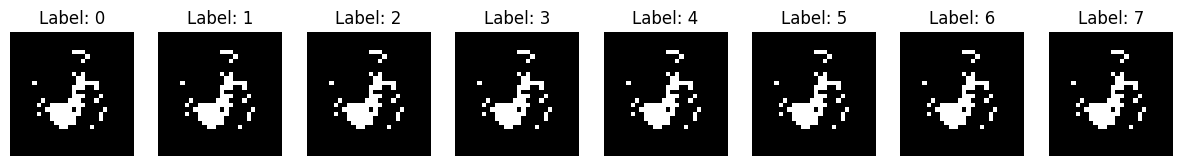

In [ ]:
import matplotlib.pyplot as plt

def generate_images(generator, device, latent_dim, labels):
    generator.eval()
    z = torch.randn(len(labels), latent_dim, device=device)
    labels = torch.tensor(labels, device=device)

    with torch.no_grad():
        gen_imgs = generator(z, labels).cpu()

    fig, axes = plt.subplots(1, len(labels), figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(gen_imgs[i].squeeze(0), cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")

    plt.show()

# Example: Generate digits 0-7
generate_images(generator, device, latent_dim, labels=[0, 1, 2, 3, 4, 5, 6, 7])